# Fashion MNIST

This is a modified version of the example code in the course.

In [33]:
import os
import shutil
import sys

assert sys.version_info >= (3, 8), "This project requires Python 3.8+"

In [34]:
from packaging import version
import torch

In [35]:
assert version.parse(torch.__version__) >= version.parse(
    "2.1.2"
), "This project requires pytorch 2.1.1 or above!"

In [36]:
# src: https://youtu.be/lS0vvIWiahU
try:
    import google.colab

    COLAB = True
    print("Note: using Google CoLab")
except:
    print("Note: not using Google CoLab")
    COLAB = False

# Make use of a GPU or MPS (Apple) if one is available
device = (
    "mps" if torch.backends.mps.is_built() else "cuda" if torch.backends.cuda.is_built() else "cpu"
)

print(f"Using device: {device}")

Note: not using Google CoLab
Using device: mps


In [37]:
%matplotlib inline
%config InlineBackend.figure_format = "svg"

import matplotlib.pyplot as plt

plt.rc("font", size=14)
plt.rc("axes", labelsize=14, titlesize=14)
plt.rc("legend", fontsize=14)
plt.rc("xtick", labelsize=10)
plt.rc("ytick", labelsize=10)

In [38]:
from torch import nn, optim
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
from tqdm import tqdm

torch.random.manual_seed(42)

## Data sets and Data Loader

Code for processing data samples can get messy and hard to maintain; we ideally want our dataset code to be decoupled from our model training code for better readability and modularity. PyTorch provides two data primitives: `torch.utils.data.DataLoader` and `torch.utils.data.Dataset` that allow you to use pre-loaded datasets as well as your own data. Dataset stores the samples and their corresponding labels, and DataLoader wraps an iterable around the Dataset to enable easy access to the samples.

PyTorch domain libraries provide a number of pre-loaded datasets (such as FashionMNIST) that subclass `torch.utils.data.Dataset` and implement functions specific to the particular data. They can be used to prototype and benchmark your model. You can find them here: Image Datasets, Text Datasets, and Audio Datasets


In [39]:
from torch.utils.data import random_split

train_dataset = datasets.FashionMNIST(
    root="./data", train=True, download=True, transform=ToTensor()
)
test_ds = datasets.FashionMNIST(root="./data", train=False, download=True, transform=ToTensor())

train_ds, val_ds = random_split(train_dataset, [50000, 10000])

In [40]:
print("train+val size: ", train_dataset.data.shape)
print("test size: ", test_ds.data.shape)

train+val size:  torch.Size([60000, 28, 28])
test size:  torch.Size([10000, 28, 28])


In [41]:
# Hyper parameters
input_size = [*train_dataset.data.shape[1:]]
number_epochs = 10
batch_size = 32
learning_rate = 0.01

In [42]:
# Iterable object generated by DataLoader
train_dloader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_dloader = DataLoader(val_ds, batch_size=batch_size, shuffle=True)
test_dloader = DataLoader(test_ds, batch_size=batch_size)  # Doesn't have to get shuffled

In [43]:
# - DataLoader makes iterable object out of DataSets
#   - the iterable (`getitem` dunder) will return both _data_ and the corresponding _label_
data, label = next(iter(train_dloader))
print("Data:\t", data.size())
print("Label:\t", label.size())

Data:	 torch.Size([32, 1, 28, 28])
Label:	 torch.Size([32])


100%|██████████| 9/9 [00:00<00:00, 176.13it/s]


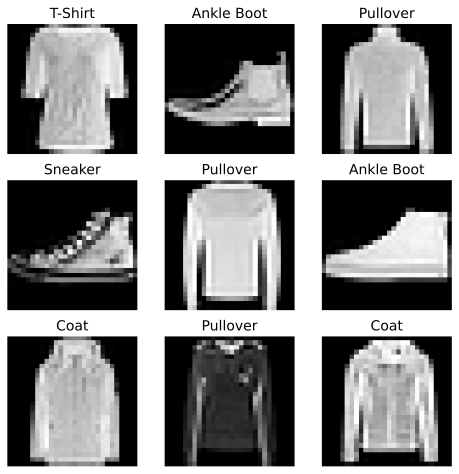

In [44]:
# Q: How do we know this is the correct map?
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}

fig = plt.figure(figsize=(8, 8))

cols, rows = 3, 3
for i in tqdm(range(1, cols * rows + 1)):
    sample_idx = torch.randint(len(train_dataset), size=(1,)).item()
    img, label = train_dataset[sample_idx]  # img is our data
    fig.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")  # Q: What does squeeze do?
plt.show()

In [80]:
# Activation function of ReLU can be called in various ways:

# import torch.nn.functional as F
# F.relu(output)

# nn.ReLU()(output)

# relu = nn.ReLU(output)


class MLP(nn.Module):
    def __init__(self, in_feature: int, output_feature: int, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(in_feature, 300)  # fc: fully connected
        # self.bn1 = nn.BatchNorm1d(300)
        self.fc2 = nn.Linear(300, 100)
        # self.bn2 = nn.BatchNorm1d(100)
        self.fc3 = nn.Linear(100, output_feature)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.flatten(x)  # (28,28) tensor -> (784,) tensor
        output = self.fc1(x)
        output = nn.ReLU()(output)
        output = self.fc2(output)
        output = nn.ReLU()(output)
        return self.fc3(output)


# # Another way to define the model
# model = nn.Sequential(
#     nn.Flatten(),
#     nn.Linear(784, 300),
#     nn.ReLU(),
#     nn.Dropout(0.2),
#     nn.Linear(300, 100),
#     nn.ReLU(),
#     nn.Dropout(0.2),
#     nn.Linear(100, 10),
# )

# 784 = 28 * 28: number of pixels, 10: number of labels
model = MLP(784, 10)
model = model.to(device)
model

MLP(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=784, out_features=300, bias=True)
  (fc2): Linear(in_features=300, out_features=100, bias=True)
  (fc3): Linear(in_features=100, out_features=10, bias=True)
)

In [81]:
# Returns a generator
model.parameters()

<generator object Module.parameters at 0x300813bc0>

In [82]:
first_param = next(iter(model.parameters()))
first_param

Parameter containing:
tensor([[-0.0218, -0.0040, -0.0355,  ..., -0.0139, -0.0056,  0.0299],
        [ 0.0151, -0.0150, -0.0303,  ...,  0.0012,  0.0307,  0.0104],
        [-0.0022, -0.0038,  0.0257,  ..., -0.0056, -0.0257, -0.0224],
        ...,
        [ 0.0311,  0.0346, -0.0209,  ...,  0.0245,  0.0158, -0.0292],
        [ 0.0339,  0.0251,  0.0005,  ..., -0.0243,  0.0032,  0.0285],
        [ 0.0262,  0.0206, -0.0312,  ..., -0.0055, -0.0249, -0.0028]],
       device='mps:0', requires_grad=True)

In [83]:
num_params = len(list(model.parameters()))
num_params

6

In [84]:
i = 0
for param in model.parameters():
    print(f"Layer {(i)//2 + 1}. ", end="")
    if i % 2 == 0:
        print("w (transpose): ", end="")
    else:
        print("b: ", end="")
    print(param.shape, "\tnum elems: ", param.numel())
    i += 1

Layer 1. w (transpose): torch.Size([300, 784]) 	num elems:  235200
Layer 1. b: torch.Size([300]) 	num elems:  300
Layer 2. w (transpose): torch.Size([100, 300]) 	num elems:  30000
Layer 2. b: torch.Size([100]) 	num elems:  100
Layer 3. w (transpose): torch.Size([10, 100]) 	num elems:  1000
Layer 3. b: torch.Size([10]) 	num elems:  10


In [85]:
x = torch.randn(10, 3, requires_grad=True)
x.requires_grad = False  # require_grad: property
# If set to True, autograd will compute the gradient during backpropagation
# and updates that tensor, otherwise doesn't

In [86]:
from datetime import datetime

# For checkpoint
# During training parameters are saved to file so that
# we can refer back to the best parameters when needed
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

saving_path = "saved_models/fashion_mnist"

In [87]:
# Model description
print("-" * 20)
print("model: ", model)
model_total_params = sum(p.numel() for p in model.parameters())
model_total_trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("model total parameters: ", model_total_params)
print("model total trainable parameters: ", model_total_trainable_params)

--------------------
model:  MLP(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=784, out_features=300, bias=True)
  (fc2): Linear(in_features=300, out_features=100, bias=True)
  (fc3): Linear(in_features=100, out_features=10, bias=True)
)
model total parameters:  266610
model total trainable parameters:  266610


In [88]:
# Loss and optimizer
criterion = nn.CrossEntropyLoss()  # Compute of loss
optimizer = optim.Adam(model.parameters(), lr=learning_rate)  # Optimization

In [89]:
epoch_number = 10
best_vloss = 1_000_000.0
train_losses, val_losses = [], []

In [92]:
for epoch in range(number_epochs):
    print(f"EPOCH {epoch + 1}:")

    running_loss = 0.0
    last_loss = 0.0

    model.train(True)
    for batch_idx, (data, targets) in enumerate(tqdm(train_dloader)):
        data = data.to(device=device)
        targets = targets.to(device=device)

        # Make predictions for this batch (feed forward)
        outputs = model(data)

        # Compute the loss and its gradients
        loss = criterion(outputs, targets)
        optimizer.zero_grad()  # torch's autograd by default adds/accumulates gradient to previous values
        loss.backward()  # Compute gradients using backward propagation automatic differentiation

        # Adjust learning weights
        optimizer.step()  # Update the parameters using the derivative computed by `loss.backward()`

        running_loss += loss.item()  # Reutrns the numerical value of the loss

        if batch_idx % 500 == 499:
            last_loss = running_loss / 500  # Loss per batch
            print(f"batch {batch_idx + 1} loss: {last_loss}")
            running_loss = 0.0

    running_vloss = 0.0
    model.eval()

    # Disable gradient computation and reduce memory consumption
    with torch.no_grad():
        for i, (vinputs, vlabels) in enumerate(val_dloader):
            vinputs = vinputs.to(device)
            vlabels = vlabels.to(device)
            voutputs = model(vinputs)
            vloss = criterion(voutputs, vlabels)
            running_vloss += vloss
    avg_vloss = running_vloss / (i + 1)
    print(f"LOSS train {last_loss} valid {avg_vloss}")

    train_losses.append(last_loss)
    val_losses.append(avg_vloss)

    # Track best performance, and save the model's state
    if avg_vloss < best_vloss:
        best_vloss = avg_vloss
        if os.path.exists(saving_path):
            shutil.rmtree(saving_path)
        os.makedirs(saving_path)
        model_path = f"{saving_path}/model_{timestamp}_{epoch_number}.pth"
        torch.save(model.state_dict(), model_path)

    epoch_number += 1

EPOCH 1:


 34%|███▎      | 526/1563 [00:02<00:04, 235.90it/s]

batch 500 loss: 0.41824271507561206


 67%|██████▋   | 1048/1563 [00:04<00:02, 240.67it/s]

batch 1000 loss: 0.42305370591580865


 99%|█████████▉| 1546/1563 [00:06<00:00, 231.55it/s]

batch 1500 loss: 0.4115681595951319


100%|██████████| 1563/1563 [00:06<00:00, 228.37it/s]


LOSS train 0.4115681595951319 valid 0.4409959614276886
EPOCH 2:


 35%|███▍      | 543/1563 [00:02<00:04, 238.46it/s]

batch 500 loss: 0.4038749319165945


 67%|██████▋   | 1040/1563 [00:04<00:02, 237.07it/s]

batch 1000 loss: 0.4035190764814615


 98%|█████████▊| 1532/1563 [00:06<00:00, 235.51it/s]

batch 1500 loss: 0.4049707351475954


100%|██████████| 1563/1563 [00:06<00:00, 235.92it/s]


LOSS train 0.4049707351475954 valid 0.40454989671707153
EPOCH 3:


 35%|███▌      | 548/1563 [00:02<00:04, 246.04it/s]

batch 500 loss: 0.40822612354159354


 66%|██████▌   | 1027/1563 [00:04<00:02, 248.47it/s]

batch 1000 loss: 0.3972820332571864


 98%|█████████▊| 1533/1563 [00:06<00:00, 249.23it/s]

batch 1500 loss: 0.38229075333476065


100%|██████████| 1563/1563 [00:06<00:00, 242.75it/s]


LOSS train 0.38229075333476065 valid 0.392993688583374
EPOCH 4:


 35%|███▍      | 544/1563 [00:02<00:04, 236.75it/s]

batch 500 loss: 0.3634251366108656


 66%|██████▋   | 1038/1563 [00:04<00:02, 245.75it/s]

batch 1000 loss: 0.39639111670851707


 99%|█████████▉| 1548/1563 [00:06<00:00, 240.42it/s]

batch 1500 loss: 0.3756600000411272


100%|██████████| 1563/1563 [00:06<00:00, 227.72it/s]


LOSS train 0.3756600000411272 valid 0.4126792550086975
EPOCH 5:


 34%|███▍      | 529/1563 [00:02<00:04, 248.90it/s]

batch 500 loss: 0.379915813036263


 67%|██████▋   | 1047/1563 [00:04<00:02, 256.77it/s]

batch 1000 loss: 0.3645036218315363


 99%|█████████▊| 1541/1563 [00:06<00:00, 255.60it/s]

batch 1500 loss: 0.3709263065755367


100%|██████████| 1563/1563 [00:06<00:00, 245.84it/s]


LOSS train 0.3709263065755367 valid 0.4656219482421875
EPOCH 6:


 34%|███▍      | 528/1563 [00:02<00:04, 241.75it/s]

batch 500 loss: 0.38160655949264766


 66%|██████▌   | 1029/1563 [00:04<00:02, 244.77it/s]

batch 1000 loss: 0.3739663072377443


 98%|█████████▊| 1532/1563 [00:06<00:00, 244.03it/s]

batch 1500 loss: 0.3617221909612417


100%|██████████| 1563/1563 [00:06<00:00, 242.88it/s]


LOSS train 0.3617221909612417 valid 0.39987829327583313
EPOCH 7:


 34%|███▎      | 526/1563 [00:02<00:04, 246.23it/s]

batch 500 loss: 0.3663966736868024


 66%|██████▌   | 1026/1563 [00:04<00:02, 246.14it/s]

batch 1000 loss: 0.3674643064439297


 98%|█████████▊| 1525/1563 [00:06<00:00, 245.50it/s]

batch 1500 loss: 0.38341572031378746


100%|██████████| 1563/1563 [00:06<00:00, 243.22it/s]


LOSS train 0.38341572031378746 valid 0.41312381625175476
EPOCH 8:


 34%|███▎      | 526/1563 [00:02<00:04, 245.48it/s]

batch 500 loss: 0.3589688964784145


 66%|██████▌   | 1027/1563 [00:04<00:02, 235.59it/s]

batch 1000 loss: 0.35886006143689153


 98%|█████████▊| 1525/1563 [00:06<00:00, 235.05it/s]

batch 1500 loss: 0.35841057124733927


100%|██████████| 1563/1563 [00:06<00:00, 242.60it/s]


LOSS train 0.35841057124733927 valid 0.4064582288265228
EPOCH 9:


 34%|███▎      | 524/1563 [00:02<00:04, 234.00it/s]

batch 500 loss: 0.36220501209795475


 67%|██████▋   | 1048/1563 [00:04<00:02, 236.85it/s]

batch 1000 loss: 0.3583596431016922


 98%|█████████▊| 1532/1563 [00:06<00:00, 227.23it/s]

batch 1500 loss: 0.36669120559096335


100%|██████████| 1563/1563 [00:06<00:00, 229.17it/s]


LOSS train 0.36669120559096335 valid 0.39971113204956055
EPOCH 10:


 34%|███▍      | 534/1563 [00:02<00:04, 217.06it/s]

batch 500 loss: 0.35101861296594145


 66%|██████▋   | 1039/1563 [00:04<00:02, 231.41it/s]

batch 1000 loss: 0.3481689041629434


 98%|█████████▊| 1537/1563 [00:06<00:00, 229.06it/s]

batch 1500 loss: 0.36037182816118


100%|██████████| 1563/1563 [00:06<00:00, 230.12it/s]


LOSS train 0.36037182816118 valid 0.41591155529022217


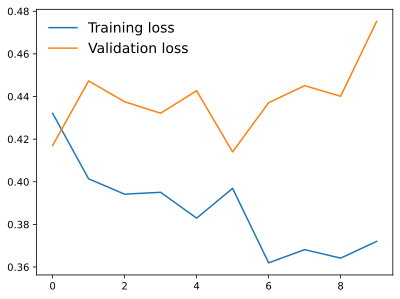

In [ ]:
plt.plot(train_losses, label="Training loss")
plt.plot(val_losses, label="Validation loss")
plt.legend(frameon=False)
plt.show()

In [ ]:
import glob

if len(glob.glob(f"{saving_path}/*.pth")) > 0:
    saved_model_params = glob.glob(f"{saving_path}/*.pth")[0]

loaded_model = MLP(784, 10)
# loaded_model = nn.Sequential(nn.Flatten(),
#     nn.Linear(784, 300),
#     nn.ReLU(),
#     nn.Linear(300, 100),
#     nn.ReLU(),
#     nn.Linear(100, 10))
loaded_model.load_state_dict(torch.load(saved_model_params))

<All keys matched successfully>